In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('C:/Users/dbsgu/ratings.csv')
books = pd.read_csv('C:/Users/dbsgu/books.csv')

In [3]:
# 사용자가 어떤 book을 평가했는지에 대한 데이터
print(data.shape)
data.head()

(981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
# 책에 대한 정보
print(books.shape)
books.head()

(10000, 23)


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [7]:
train, test = train_test_split(data, test_size = 0.2)
print(train.shape, test.shape)
train.head()

(785404, 3) (196352, 3)


,book_id,user_id,rating
929133,9432,5427,5
874482,8849,35960,5
384133,3847,8790,4
133358,1334,27099,3
200970,2011,33653,3


In [8]:
number_of_unique_user = len(data.user_id.unique())
number_of_unique_book_id = len(data.book_id.unique())
print(number_of_unique_user, number_of_unique_book_id)

53424 10000


In [9]:
#1)간단한 Dot product 형태의 모델이다.
#사용자 embedding과 book embedding을 기반으로 나온 벡터 값을 Dot 연산을 통해 rating을 예측하는 방법

# layer 만들기
book_input = Input(shape=(1,), name='book_input_layer')
user_input = Input(shape=(1,), name='user_input_layer')

book_embedding_layer = Embedding(number_of_unique_book_id + 1, 8, name='book_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user + 1, 8, name='user_embedding_layer')

book_vector_layer = Flatten(name='book_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

dot_result_layer = Dot(name='dot_vector_layer', axes = 1)

In [10]:
# 쌓기
book_embedding = book_embedding_layer(book_input)
user_embedding = user_embedding_layer(user_input)

book_vector = book_vector_layer(book_embedding)
user_vector = user_vector_layer(user_embedding)

dot_result = dot_result_layer([book_vector, user_vector])
model = Model(inputs=[user_input, book_input], outputs=dot_result)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ book_input_layer (InputLayer) │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_input_layer (InputLayer) │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ book_embedding_layer          │ (None, 1, 8)              │          80,008 │ book_input_layer[0][0]     │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding_layer          │ (None, 1, 8)              │         427,400 │ user_input_layer[0][0]     │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ book_vector_layer (Flatten)   │ (None, 8)                 │               0 │ book_embedding_layer[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_vector_layer (Flatten)   │ (None, 8)                 │               0 │ user_embedding_layer[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dot_vector_layer (Dot)        │ (None, 1)                 │               0 │ book_vector_layer[0][0],   │
│                               │                           │                 │ user_vector_layer[0][0]    │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 507,408 (1.94 MB)

 Trainable params: 507,408 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

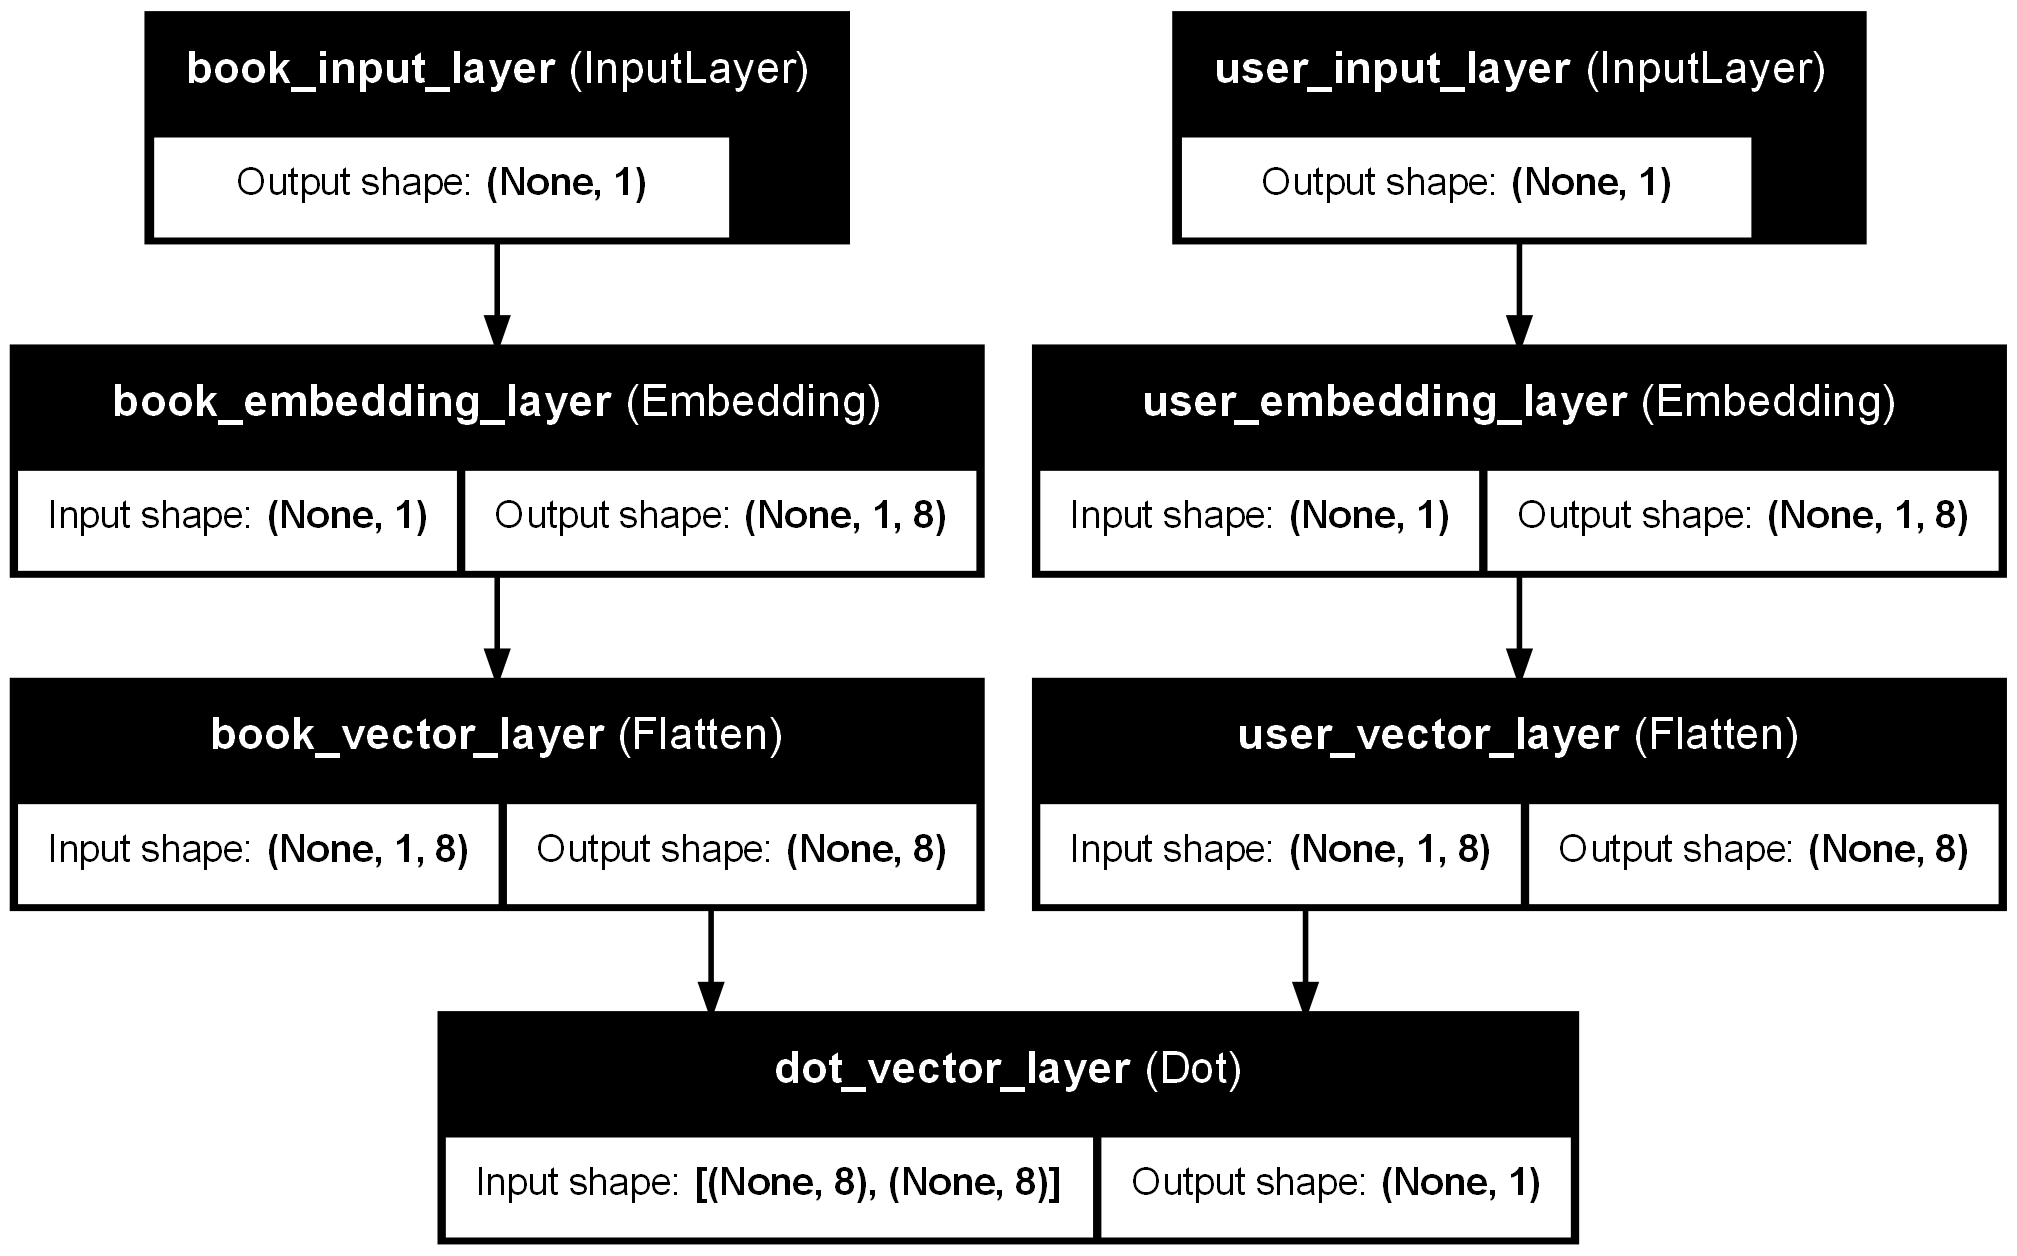

In [12]:
plot_model(model, to_file='./dot_model.png', show_shapes=True, show_layer_names=True)

In [13]:
model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

In [14]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=50, verbose=1)

Epoch 1/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - loss: 14.8581 - mse: 14.8581
Epoch 2/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 137s 6ms/step - loss: 3.9691 - mse: 3.9691
Epoch 3/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 138s 6ms/step - loss: 1.4937 - mse: 1.4937
Epoch 4/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 139s 6ms/step - loss: 1.0374 - mse: 1.0374
Epoch 5/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 139s 6ms/step - loss: 0.8603 - mse: 0.8603
Epoch 6/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - loss: 0.7731 - mse: 0.7731
Epoch 7/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 0.7263 - mse: 0.7263
Epoch 8/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 141s 6ms/step - loss: 0.6961 - mse: 0.6961
Epoch 9/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 0.6715 - mse: 0.6715
Epoch 10/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 142s 6ms/step - loss: 0.6525 - mse: 0.6525
Epoch 11/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - loss: 0.6356 - mse: 0.6356
Epoch 12/50
24544/24544 ━━━━━━━━━━━━━━━

Text(0, 0.5, 'training error')

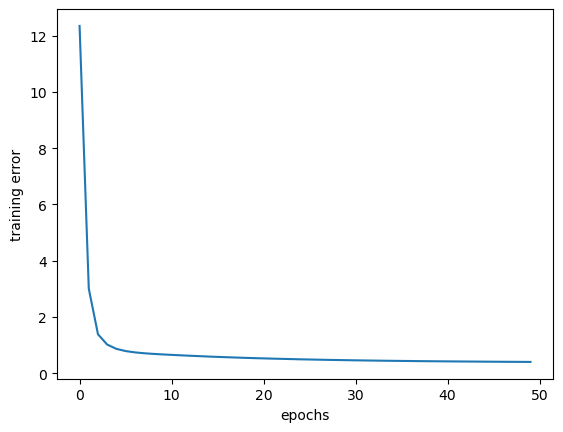

In [15]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [16]:
model.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.1236 - mse: 1.1236


[1.1228986978530884, 1.1228986978530884]

In [17]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

for p, t in zip(predictions, test.rating.values[:10]):
    print(p, t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[4.4776306] 4
[5.1125884] 5
[5.046531] 3
[3.420503] 3
[0.9936351] 2
[5.0325866] 5
[2.4269772] 4
[3.5867918] 5
[4.152871] 5
[2.9218366] 3


In [18]:
#2)Dense layer (Neural Network로 만들기)
#위에서는 단순하게 Dot을 이용해서 rating을 예측하는 형태로 만들었다.
#이번에는 Dense layer를 이용해서 layer를 쌓고 rating을 예측하는 방법을 적용해본다.

# layer 쌓기

book_input = Input(shape=(1, ), name='book_input_layer')
user_input = Input(shape=(1, ), name='user_input_layer')

book_embedding_layer = Embedding(number_of_unique_book_id + 1, 8, name='book_embedding_layer')
user_embedding_layer = Embedding(number_of_unique_user + 1, 8, name='user_embedding_layer')

book_vector_layer = Flatten(name='book_vector_layer')
user_vector_layer = Flatten(name='user_vector_layer')

concate_layer = Concatenate()

dense_layer1 = Dense(128, activation='relu')
dense_layer2 = Dense(32, activation='relu')

result_layer = Dense(1)

In [19]:
# 쌓기
book_embedding = book_embedding_layer(book_input)
user_embedding = user_embedding_layer(user_input)

book_vector = book_vector_layer(book_embedding)
user_vector = user_vector_layer(user_embedding)

concat = concate_layer([book_vector, user_vector])
dense1 = dense_layer1(concat)
dense2 = dense_layer2(dense1)

result = result_layer(dense2)

model = Model(inputs=[user_input, book_input], outputs=result)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ book_input_layer (InputLayer) │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_input_layer (InputLayer) │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ book_embedding_layer          │ (None, 1, 8)              │          80,008 │ book_input_layer[0][0]     │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding_layer          │ (None, 1, 8)              │         427,400 │ user_input_layer[0][0]     │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ book_vector_layer (Flatten)   │ (None, 8)                 │               0 │ book_embedding_layer[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_vector_layer (Flatten)   │ (None, 8)                 │               0 │ user_embedding_layer[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 16)                │               0 │ book_vector_layer[0][0],   │
│                               │                           │                 │ user_vector_layer[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           2,176 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 32)                │           4,128 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              33 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 513,745 (1.96 MB)

 Trainable params: 513,745 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

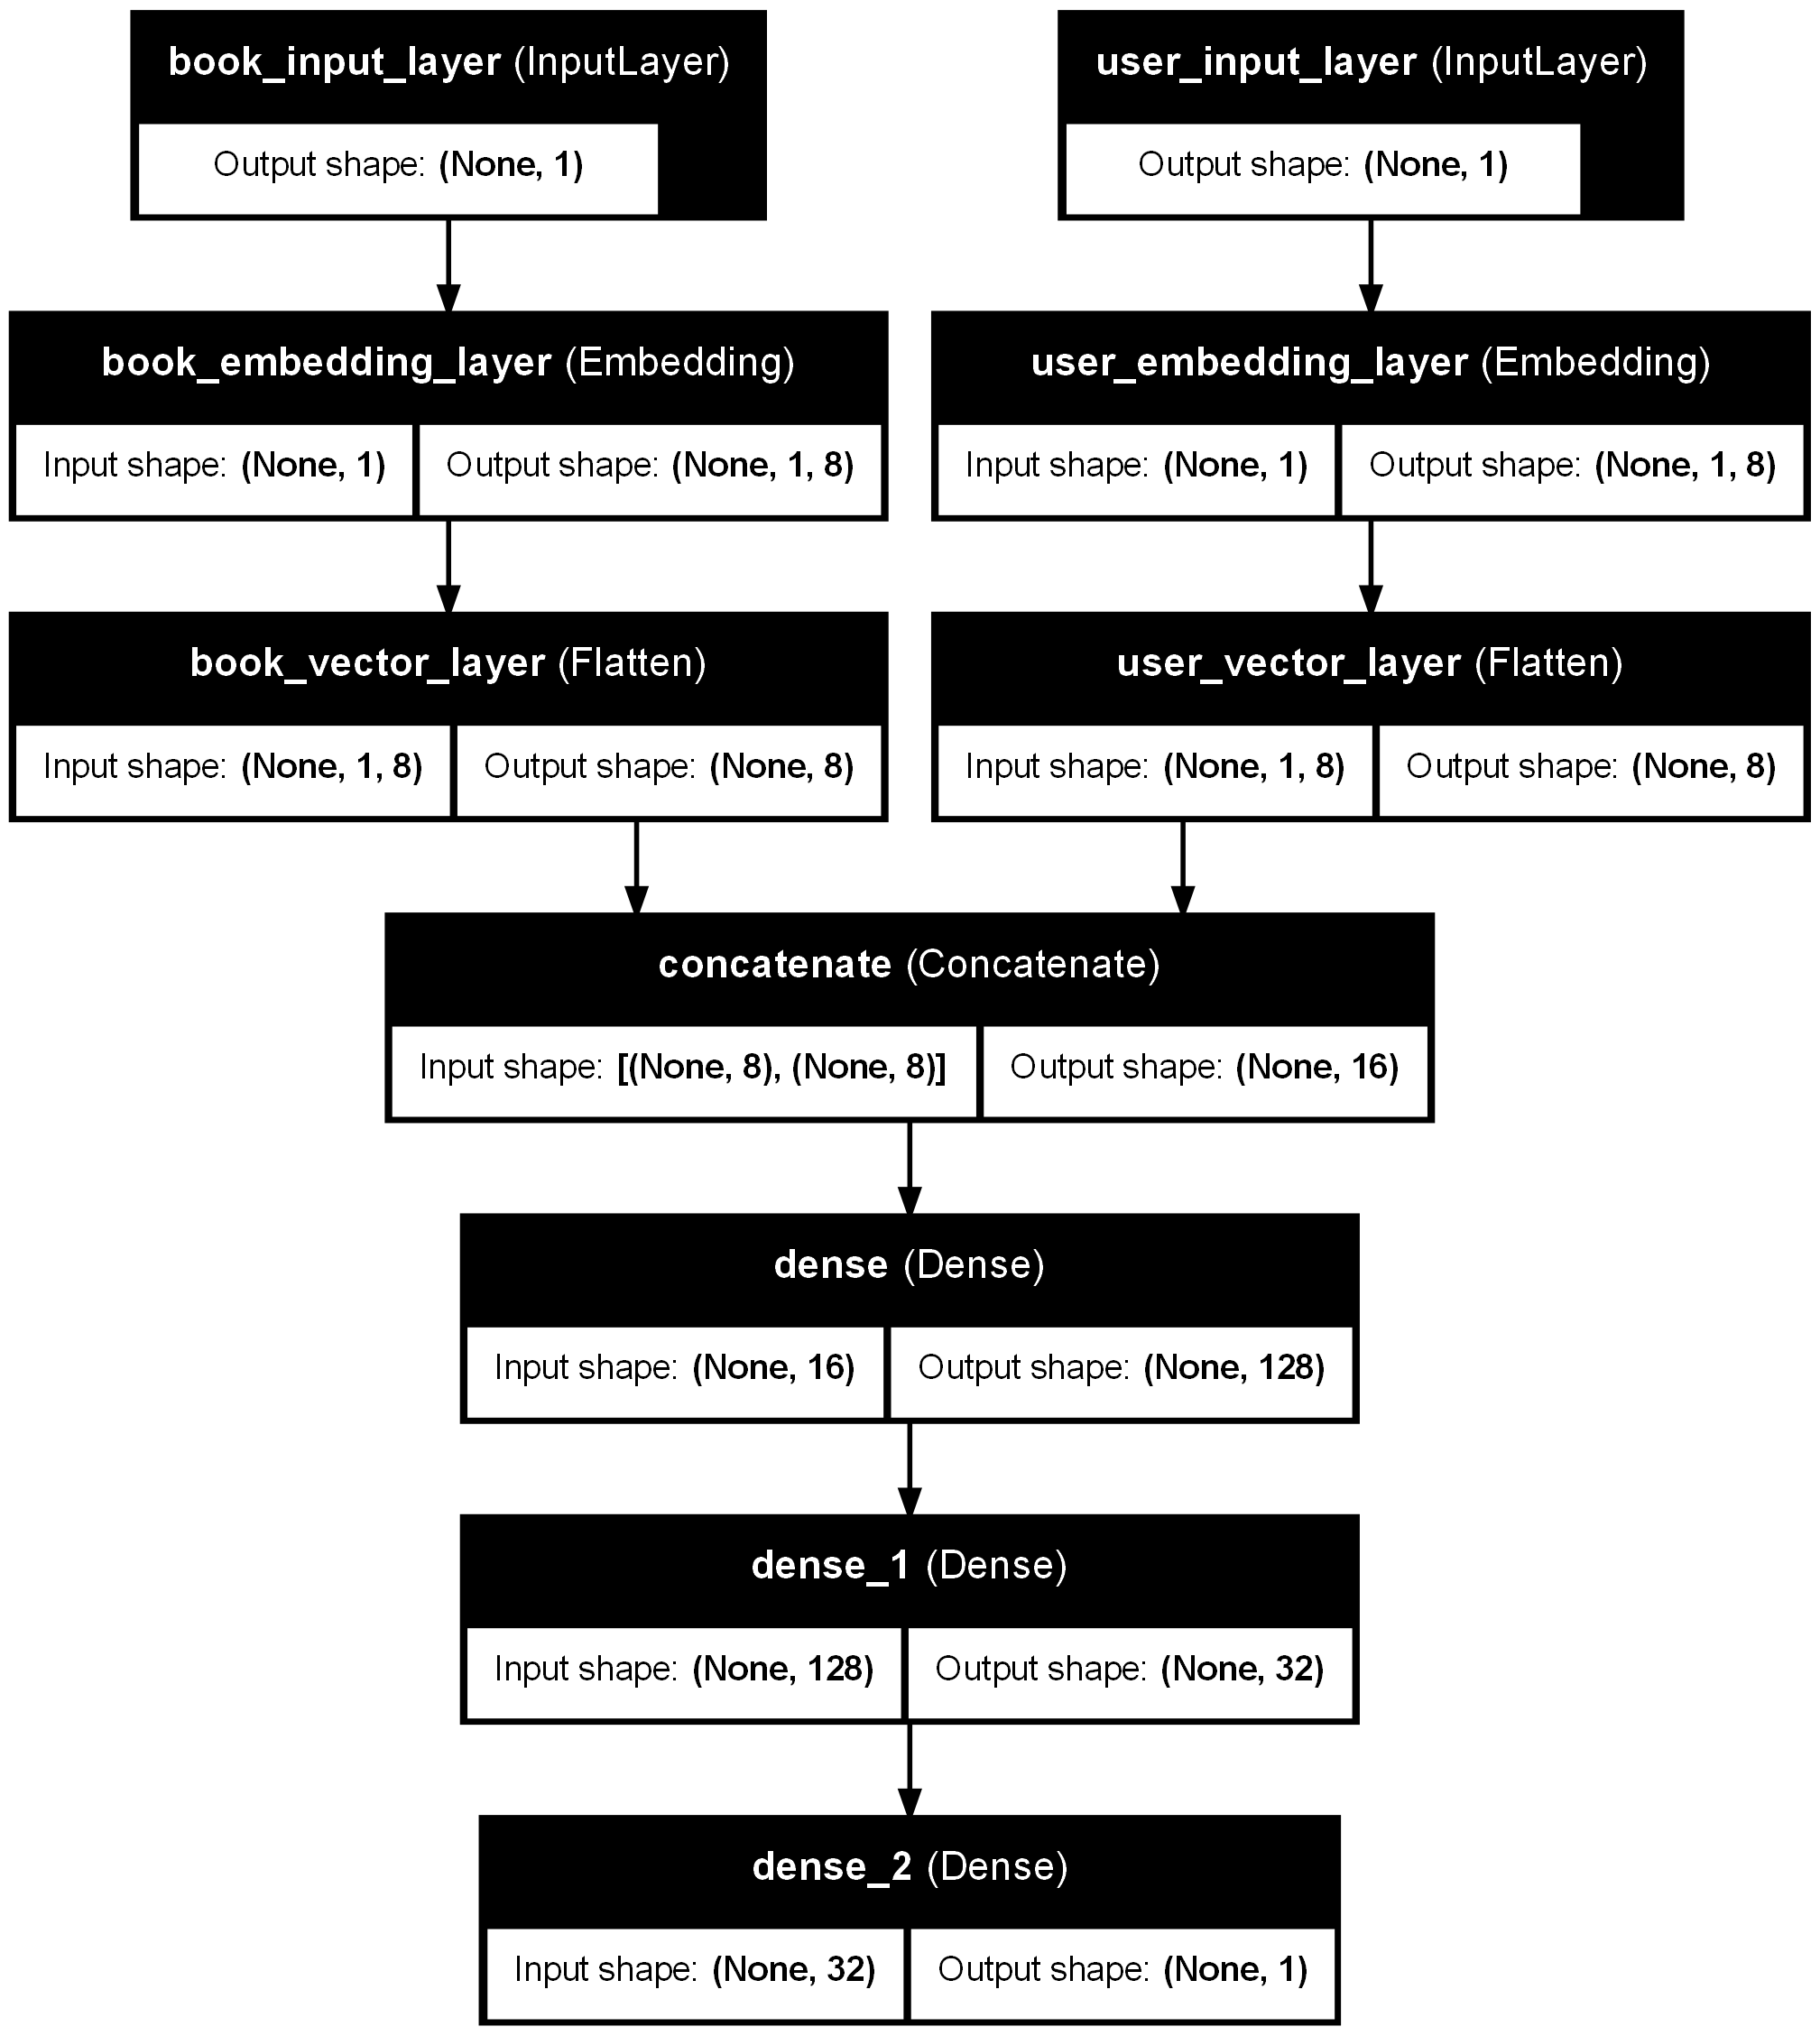

In [21]:
plot_model(model, to_file='./dense_predict_model.png', show_shapes=True, show_layer_names=True)

In [22]:
model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

In [23]:
history = model.fit([train.user_id, train.book_id], train.rating, epochs=50, verbose=1)

Epoch 1/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - loss: 0.9962 - mse: 0.9962
Epoch 2/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 163s 7ms/step - loss: 0.6823 - mse: 0.6823
Epoch 3/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - loss: 0.6469 - mse: 0.6469
Epoch 4/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 145s 6ms/step - loss: 0.6200 - mse: 0.6200
Epoch 5/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 145s 6ms/step - loss: 0.5892 - mse: 0.5892
Epoch 6/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 145s 6ms/step - loss: 0.5624 - mse: 0.5624
Epoch 7/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 175s 7ms/step - loss: 0.5381 - mse: 0.5381
Epoch 8/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 190s 8ms/step - loss: 0.5106 - mse: 0.5106
Epoch 9/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 172s 7ms/step - loss: 0.4876 - mse: 0.4876
Epoch 10/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 149s 6ms/step - loss: 0.4680 - mse: 0.4680
Epoch 11/50
24544/24544 ━━━━━━━━━━━━━━━━━━━━ 152s 6ms/step - loss: 0.4521 - mse: 0.4521
Epoch 12/50
24544/24544 ━━━━━━━━━━━━━━━━━

Text(0, 0.5, 'training error')

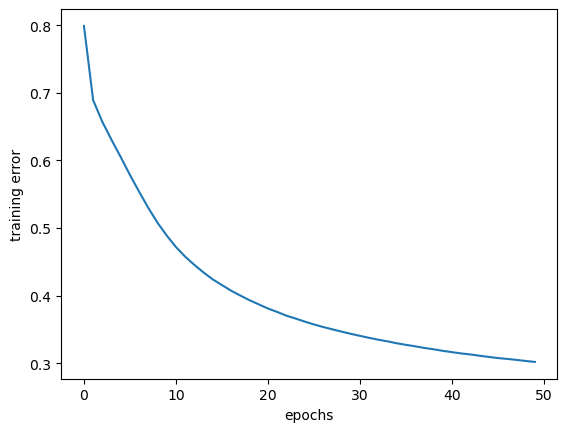

In [24]:
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('training error')

In [25]:
model.evaluate([test.user_id, test.book_id], test.rating)

6136/6136 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.9575 - mse: 0.9575


[0.9578167200088501, 0.9578167200088501]

In [26]:
predictions = model.predict([test.user_id.head(10), test.book_id.head(10)])

for p, t in zip(predictions, test.rating.values[:10]):
    print(p, t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
[3.6753526] 4
[4.5014415] 5
[4.897477] 3
[1.3451874] 3
[1.0744113] 2
[4.3375416] 5
[3.870479] 4
[3.503039] 5
[4.663416] 5
[4.7310038] 3


In [27]:
tmp_book_data = np.array(list(set(data.book_id)))[:1000]
tmp_user = np.array([1 for i in range(1000)])

In [28]:
print(tmp_book_data[:10])
print(tmp_user[:10])

[ 1  2  3  4  5  6  7  8  9 10]
[1 1 1 1 1 1 1 1 1 1]


In [29]:
predictions = model.predict([tmp_user, tmp_book_data])
predictions = np.array([p[0] for p in predictions])
print(predictions[:5])

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[4.7547784 4.845057  3.6383572 4.96868   2.838523 ]


In [30]:
# id는 1부터 시작인데 argsort를 하면 0부터 되므로 1을 더한다.
recommended_book_ids = (-predictions).argsort()[:5] + 1
print(recommended_book_ids)

[998 983 291 135  25]


In [31]:
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
24,25,136251,136251,2963218,263,545010225,9.780545e+12,"J.K. Rowling, Mary GrandPré",2007.0,Harry Potter and the Deathly Hallows,...,1746574,1847395,51942,9363,22245,113646,383914,1318227,https://images.gr-assets.com/books/1474171184m...,https://images.gr-assets.com/books/1474171184s...
134,135,62291,62291,1164465,175,055357342X,9.780554e+12,George R.R. Martin,2000.0,A Storm of Swords,...,469022,527644,19497,1456,4820,36418,149268,335682,https://images.gr-assets.com/books/1497931121m...,https://images.gr-assets.com/books/1497931121s...
290,291,3591262,3591262,3633533,74,375414495,9.780375e+12,Abraham Verghese,2009.0,Cutting for Stone,...,258319,281079,23146,4586,9249,32671,91293,143280,https://images.gr-assets.com/books/1327931601m...,https://images.gr-assets.com/books/1327931601s...
982,983,25489625,25489625,44848425,36,812993543,9.780813e+12,Ta-Nehisi Coates,2015.0,Between the World and Me,...,74218,102946,13113,1438,2375,9177,30541,59415,https://images.gr-assets.com/books/1451435027m...,https://images.gr-assets.com/books/1451435027s...
997,998,44186,44186,640276,23,037582913X,9.780376e+12,"Jon Stone, Michael J. Smollin",1971.0,The Monster at the End of This Book,...,102184,104970,2504,1911,2537,10567,21477,68478,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
